In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly
import seaborn as sns; sns.set()
from matplotlib import dates
import altair as alt
import math
from matplotlib import dates
from astropy.time import Time

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
plt.style.use('seaborn-dark-palette')

In [14]:
jedi = pd.read_csv('jedi_v1_og.csv', low_memory=False)
demon = pd.read_csv('DEMON.csv', parse_dates=[['Year', 'Month', 'Day', 'Peak Time']])


In [15]:
demon.drop(demon.index[0], inplace=True)

In [16]:
demon.drop(demon.index[4595], inplace=True)

In [17]:
demon.index = pd.DatetimeIndex(demon['Year_Month_Day_Peak Time'])
demon.index.rename('Peak Datetime', inplace=True)
demon.drop(['Year_Month_Day_Peak Time'], inplace=True, axis=1)
demon.sort_index(inplace=True)
demon = demon.convert_objects(convert_numeric=True)

C:\Users\kelly\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning:

convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.



In [18]:
demon = demon[jedi['GOES Flare Start Time'][0]: jedi['GOES Flare Start Time'][len(jedi) - 1]]
demon.head()

,Intensity,Start,End,Event #,Max Drop,Lat,Lon,dist.R,AR#,Count,Flare
Peak Datetime,,,,,,,,,,,
2010-05-23 16:46:00,-252.0,16:46,17:48,4321,44.0,28.0,-3.0,0.50,NaN,40,NaN
2010-05-24 13:24:00,-94.0,13:22,13:52,4322,62.0,17.0,33.0,0.61,NaN,24,NaN
2010-05-31 19:54:00,-281.0,19:38,20:34,4323,41.0,24.0,29.0,0.62,NaN,37,NaN
2010-06-12 01:08:00,-98.0,1:04,1:50,4324,84.0,29.0,52.0,0.85,AR 1081,32,M4
2010-06-12 09:28:00,-61.0,9:28,9:52,4325,104.0,25.0,58.0,0.88,AR 1081,21,M2


In [19]:
jedi_demon = jedi.copy()
jedi_demon['Has DEMON Dimming'] = False
jedi_demon['Intensity'] = np.nan
jedi_demon['Max Drop'] = np.nan
jedi_demon['Demon Event #'] = np.nan
jedi_demon['Demon Flare'] = np.nan

In [20]:
jedi_time = Time(jedi['GOES Flare Peak Time'].values.astype(str))
demon_time = Time(demon.index.values.astype(str))

In [21]:
for jedi_row_index in range(len(jedi)):
    ind = np.where((demon_time.jd <= (0.9/24. + jedi_time[jedi_row_index].jd)) & (demon_time.jd >= (jedi_time[jedi_row_index].jd - 0.1/24.))) # See if DEMON dimming and GOES flare are within an hour of each other
    if ind[0].size == 1:
        jedi_demon['Has DEMON Dimming'].iloc[jedi_row_index] = True
    elif ind[0].size > 1:
        jedi_demon['Has DEMON Dimming'].iloc[jedi_row_index] = ind[0].size
    if ind[0].size > 0:
        jedi_demon['Intensity'].iloc[jedi_row_index] = demon['Intensity'].iloc[ind[0]].values[0]
        jedi_demon['Max Drop'].iloc[jedi_row_index] = demon['Max Drop'].iloc[ind[0]].values[0]
        jedi_demon['Demon Event #'].iloc[jedi_row_index] = demon['Event #'].iloc[ind[0]].values[0]
        jedi_demon['Demon Flare'].iloc[jedi_row_index] = demon['Flare'].iloc[ind[0]].values[0]

C:\Users\kelly\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [22]:
jedi.head()

,Event #,GOES Flare Start Time,GOES Flare Peak Time,GOES Flare Class,Pre-Flare Start Time,Pre-Flare End Time,Flare Interrupt,9.4 Pre-Flare Irradiance [W/m2],13.1 Pre-Flare Irradiance [W/m2],13.3 Pre-Flare Irradiance [W/m2],...,103.2 by 63.0 Fitting Score,103.2 by 71.9 Fitting Score,103.2 by 72.2 Fitting Score,103.2 by 77.0 Fitting Score,103.2 by 79.0 Fitting Score,103.2 by 83.6 Fitting Score,103.2 by 95.0 Fitting Score,103.2 by 97.3 Fitting Score,103.2 by 97.7 Fitting Score,103.2 by 102.6 Fitting Score
0,1.0,2010-05-04 16:15:00.000,2010-05-04 16:29:00.000,C3.6,2010-05-04 08:29:00.000,2010-05-04 16:29:00.000,True,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,2010-05-05 07:09:00.000,2010-05-05 07:16:00.000,C2.3,2010-05-04 23:16:00.000,2010-05-05 07:16:00.000,True,0.000004,0.000002,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,2010-05-05 11:37:00.000,2010-05-05 11:52:00.000,C8.8,2010-05-04 23:16:00.000,2010-05-05 07:16:00.000,True,0.000004,0.000002,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,2010-05-05 17:13:00.000,2010-05-05 17:19:00.000,M1.2,2010-05-04 23:16:00.000,2010-05-05 07:16:00.000,False,0.000004,0.000002,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,2010-05-07 07:29:00.000,2010-05-07 07:42:00.000,C2.0,2010-05-06 23:42:00.000,2010-05-07 07:42:00.000,True,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
flare_conversion = {"A": 1, "B": 10, "C": 100, "M": 1000, "X":10000}
flareClass = jedi_demon.loc[:, 'GOES Flare Class'].values
flareClass.flatten()



array(['C3.6', 'C2.3', 'C8.8', ..., 'C1.9', 'C3.0', 'C2.8'], dtype=object)

In [24]:
tempString = flareClass[4]
type(tempString)

str

In [25]:
flare_converted = []
tempBool = True
for k in range(len(flareClass)):
    tempBool = True
    for i, v in flare_conversion.items():
        tempString = flareClass[k]
        tempString = str(tempString)
        if tempString[:1] == i:
            flare_converted.append(round((float(tempString[1:]) * v)))
            tempBool = False
            
    if tempBool and math.isnan(float(tempString)) :
            flare_converted.append(np.nan)

In [26]:
flare_converted;

In [27]:
flare_converted_arr = np.array(flare_converted)

In [28]:
jedi_demon.insert(4, 'Flare Class Converted', flare_converted_arr)


In [29]:
demon['2011-10-01']

,Intensity,Start,End,Event #,Max Drop,Lat,Lon,dist.R,AR#,Count,Flare
Peak Datetime,,,,,,,,,,,
2011-10-01 01:04:00,-69.0,1:04,1:28,4857,66.0,9.0,-11.0,0.19,AR 1306,21,NaN
2011-10-01 08:32:00,-50.0,8:24,8:48,4858,17.0,7.0,-10.0,0.17,AR 1306,21,NaN
2011-10-01 10:02:00,-949.0,9:10,13:10,4859,393.0,23.0,40.0,0.67,AR 1302,129,M1
2011-10-01 21:02:00,-182.0,20:30,22:06,4860,43.0,NaN,NaN,1.11,NaN,56,NaN


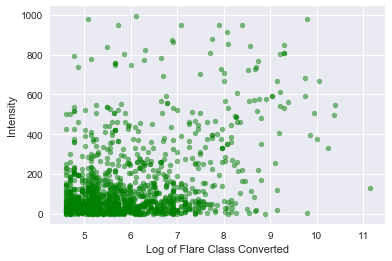

In [30]:
plt.scatter(np.log(jedi_demon.loc[:, 'Flare Class Converted']), np.abs(jedi_demon.loc[:, 'Intensity']),
            alpha=.5, s=25, color='green');
plt.xlabel('Log of Flare Class Converted');
plt.ylabel('Intensity')
plt.savefig('Log of Flare Class VS Intensity')

In [31]:
demon_copy = demon.copy()
start_time = demon['Start'].values
end_time = demon['End'].values

end_time.shape

(3089,)

In [32]:

def turnIntoSeconds(timeArray):
    secondArray = []
    for i in range(len(timeArray)):
        timeValue = timeArray[i]
        if len(timeValue) == 5:
            hours = timeValue[:2]
            minutes = timeValue[3:]
        else:
            hours = timeValue[:1]
            minutes = timeValue[2:]
            
        secondHours = round(float(hours) * 60 * 60)
        minuteHours = round(float(minutes) * 60)
        
        secondArray.append((secondHours + minuteHours))
    return secondArray
            

In [33]:
tempArray = turnIntoSeconds(start_time)
start_seconds = np.array(tempArray)
tempList = turnIntoSeconds(end_time)
end_seconds = np.array(tempList)

In [34]:
start_seconds.shape

(3089,)

In [35]:
def time_diff(start, end):
    SEC_IN_DAY = 86400
    delta_time = []
    for i in range(len(end)):
        if end[i] < start[i]:
            delta_time.append(end[i] + (SEC_IN_DAY - start[i]))          
        else:
            delta_time.append(end[i] - start[i])
    return delta_time

In [36]:
dimming_time_temp = time_diff(start_seconds, end_seconds)

In [37]:
dimming_time = np.array(dimming_time_temp)
dimming_time.shape

(3089,)

In [38]:
demon.shape

(3089, 11)

In [39]:
demon.insert(3, 'Delta/Dimming Time', dimming_time)

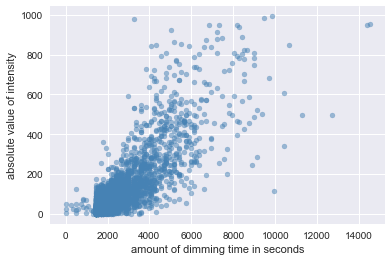

In [40]:
plt.scatter(demon.loc[:, 'Delta/Dimming Time'],
            np.abs(demon.loc[:, 'Intensity']), alpha=.5, s=25, color='steelblue')
plt.xlabel('amount of dimming time in seconds')
plt.ylabel('absolute value of intensity')
plt.savefig('Dimming Time vs Intensity')

In [41]:
np.mean(demon.loc[:,'Delta/Dimming Time'])

2679.3136937520235

In [42]:
multiple_matches_df = jedi_demon.loc[(jedi_demon['Has DEMON Dimming'] > 1), "Has DEMON Dimming"]
single_matches_df = jedi_demon.loc[(jedi_demon['Has DEMON Dimming'] == True), "Has DEMON Dimming"]
no_matches_df = jedi_demon.loc[(jedi_demon['Has DEMON Dimming']) == False, "Has DEMON Dimming"]
print('# multiple matches: {0} # single matches: {1} # no matches {2}'.format(len(multiple_matches_df),
      len(single_matches_df), len(no_matches_df)))

# multiple matches: 34 # single matches: 1329 # no matches 3407


In [43]:
jedi_demon.to_csv('jedi_demon_time_match.csv', header=True, index=False, mode='w')

In [44]:
# jedi_demon = pd.read_csv('jedi_demon_time_match.csv', low_memory=False)
# jedi_demon = jedi_demon.convert_objects(convert_numeric=True)

In [45]:
jedi_demon

,Event #,GOES Flare Start Time,GOES Flare Peak Time,GOES Flare Class,Flare Class Converted,Pre-Flare Start Time,Pre-Flare End Time,Flare Interrupt,9.4 Pre-Flare Irradiance [W/m2],13.1 Pre-Flare Irradiance [W/m2],...,103.2 by 83.6 Fitting Score,103.2 by 95.0 Fitting Score,103.2 by 97.3 Fitting Score,103.2 by 97.7 Fitting Score,103.2 by 102.6 Fitting Score,Has DEMON Dimming,Intensity,Max Drop,Demon Event #,Demon Flare
0,1.0,2010-05-04 16:15:00.000,2010-05-04 16:29:00.000,C3.6,360,2010-05-04 08:29:00.000,2010-05-04 16:29:00.000,True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
1,2.0,2010-05-05 07:09:00.000,2010-05-05 07:16:00.000,C2.3,230,2010-05-04 23:16:00.000,2010-05-05 07:16:00.000,True,0.000004,0.000002,...,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
2,3.0,2010-05-05 11:37:00.000,2010-05-05 11:52:00.000,C8.8,880,2010-05-04 23:16:00.000,2010-05-05 07:16:00.000,True,0.000004,0.000002,...,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
3,4.0,2010-05-05 17:13:00.000,2010-05-05 17:19:00.000,M1.2,1200,2010-05-04 23:16:00.000,2010-05-05 07:16:00.000,False,0.000004,0.000002,...,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
4,5.0,2010-05-07 07:29:00.000,2010-05-07 07:42:00.000,C2.0,200,2010-05-06 23:42:00.000,2010-05-07 07:42:00.000,True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
5,6.0,2010-05-08 04:51:00.000,2010-05-08 04:59:00.000,C9.3,930,2010-05-07 20:59:00.000,2010-05-08 04:59:00.000,True,NaN,0.000002,...,NaN,NaN,NaN,0.329834,0.073395,False,NaN,NaN,NaN,NaN
6,7.0,2010-05-08 11:40:00.000,2010-05-08 11:50:00.000,C1.8,180,2010-05-07 20:59:00.000,2010-05-08 04:59:00.000,True,NaN,0.000002,...,NaN,NaN,NaN,0.126622,NaN,False,NaN,NaN,NaN,NaN
7,9.0,2010-06-12 00:30:00.000,2010-06-12 00:57:00.000,M2.0,2000,2010-06-11 16:57:00.000,2010-06-12 00:57:00.000,True,NaN,0.000002,...,NaN,NaN,NaN,NaN,NaN,True,-98.0,84.0,4324.0,M4
8,10.0,2010-06-12 03:57:00.000,2010-06-12 04:06:00.000,C1.0,100,2010-06-11 16:57:00.000,2010-06-12 00:57:00.000,True,NaN,0.000002,...,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
9,11.0,2010-06-12 09:02:00.000,2010-06-12 09:17:00.000,C6.1,610,2010-06-11 16:57:00.000,2010-06-12 00:57:00.000,True,NaN,0.000002,...,NaN,NaN,NaN,NaN,NaN,True,-61.0,104.0,4325.0,M2


In [46]:
event_nums = jedi_demon[['Event #']].values
duplicate_event_num = []
for i in range(len(jedi_demon)):
    for k in range(len(jedi_demon)):
        if i != k and event_nums[i] == event_nums[k]:
            duplicate_event_num.append(i)
            

In [47]:
def quad(euvOne, euvTwo, euvThree, euvFour, euvFive, euvSix, euvSeven):
    quad_list = []

    euv1 = euvOne.copy()
    euv2 = euvTwo.copy()
    euv3 = euvThree.copy()
    euv4 = euvFour.copy()
    euv5 = euvFive.copy()
    euv6 = euvSix.copy()
    euv7 = euvSeven.copy()
    
    max_dimming_percent = 100
    for i in range(len(euv1)):
        if math.isnan(euv1[i]) or euv1[i] > max_dimming_percent:
            euv1[i] = 0
        if math.isnan(euv2[i]) or euv2[i] > max_dimming_percent:
            euv2[i] = 0
        if math.isnan(euv3[i]) or euv3[i] > max_dimming_percent:
            euv3[i] = 0
        if math.isnan(euv4[i]) or euv4[i] > max_dimming_percent:
            euv4[i] = 0
        if math.isnan(euv5[i]) or euv5[i] > max_dimming_percent:
            euv5[i] = 0
        if math.isnan(euv6[i]) or euv6[i] > max_dimming_percent:
            euv6[i] = 0
        if math.isnan(euv7[i]) or euv7[i] > max_dimming_percent:
            euv7[i] = 0
    
    euv1Squared = euv1 ** 2
    euv2Squared = euv2 ** 2
    euv3Squared = euv3 ** 2
    euv4Squared = euv4 ** 2
    euv5Squared = euv5 ** 2
    euv6Squared = euv6 ** 2
    euv7Squared = euv7 ** 2
    
    for i in range(len(euv1Squared)):
        quad_list.append(math.sqrt((euv1Squared[i] + euv2Squared[i] + euv3Squared[i] + euv4Squared[i] + euv5Squared[i] + euv6Squared[i] + euv7Squared[i])))
    
    return quad_list
         

In [48]:
lis = quad(jedi_demon.loc[:, '17.1 Depth [%]'].values, jedi_demon.loc[:, '19.5 Depth [%]'].values, 
           jedi_demon.loc[:, '21.1 Depth [%]'].values, jedi_demon.loc[:, '17.7 Depth [%]'].values,
           jedi_demon.loc[:, '28.4 Depth [%]'].values, jedi_demon.loc[:, '18.0 Depth [%]'].values,
           jedi_demon.loc[:, '20.2 Depth [%]'].values)
quad_arr = np.array(lis)

In [49]:
quad_arr

array([0.        , 1.55529105, 1.11583577, ..., 0.        , 0.        ,
       0.        ])

In [50]:
for i in range(len(quad_arr)):
    if quad_arr[i] == 0 or quad_arr[i] > 20:
        quad_arr[i] = np.nan

In [51]:
quad_arr

array([       nan, 1.55529105, 1.11583577, ...,        nan,        nan,
              nan])

In [52]:
jedi_demon.insert(8, 'Quad Depth', quad_arr)

In [53]:
jedi_demon

,Event #,GOES Flare Start Time,GOES Flare Peak Time,GOES Flare Class,Flare Class Converted,Pre-Flare Start Time,Pre-Flare End Time,Flare Interrupt,Quad Depth,9.4 Pre-Flare Irradiance [W/m2],...,103.2 by 83.6 Fitting Score,103.2 by 95.0 Fitting Score,103.2 by 97.3 Fitting Score,103.2 by 97.7 Fitting Score,103.2 by 102.6 Fitting Score,Has DEMON Dimming,Intensity,Max Drop,Demon Event #,Demon Flare
0,1.0,2010-05-04 16:15:00.000,2010-05-04 16:29:00.000,C3.6,360,2010-05-04 08:29:00.000,2010-05-04 16:29:00.000,True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
1,2.0,2010-05-05 07:09:00.000,2010-05-05 07:16:00.000,C2.3,230,2010-05-04 23:16:00.000,2010-05-05 07:16:00.000,True,1.555291,0.000004,...,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
2,3.0,2010-05-05 11:37:00.000,2010-05-05 11:52:00.000,C8.8,880,2010-05-04 23:16:00.000,2010-05-05 07:16:00.000,True,1.115836,0.000004,...,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
3,4.0,2010-05-05 17:13:00.000,2010-05-05 17:19:00.000,M1.2,1200,2010-05-04 23:16:00.000,2010-05-05 07:16:00.000,False,1.833244,0.000004,...,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
4,5.0,2010-05-07 07:29:00.000,2010-05-07 07:42:00.000,C2.0,200,2010-05-06 23:42:00.000,2010-05-07 07:42:00.000,True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
5,6.0,2010-05-08 04:51:00.000,2010-05-08 04:59:00.000,C9.3,930,2010-05-07 20:59:00.000,2010-05-08 04:59:00.000,True,NaN,NaN,...,NaN,NaN,NaN,0.329834,0.073395,False,NaN,NaN,NaN,NaN
6,7.0,2010-05-08 11:40:00.000,2010-05-08 11:50:00.000,C1.8,180,2010-05-07 20:59:00.000,2010-05-08 04:59:00.000,True,NaN,NaN,...,NaN,NaN,NaN,0.126622,NaN,False,NaN,NaN,NaN,NaN
7,9.0,2010-06-12 00:30:00.000,2010-06-12 00:57:00.000,M2.0,2000,2010-06-11 16:57:00.000,2010-06-12 00:57:00.000,True,0.793027,NaN,...,NaN,NaN,NaN,NaN,NaN,True,-98.0,84.0,4324.0,M4
8,10.0,2010-06-12 03:57:00.000,2010-06-12 04:06:00.000,C1.0,100,2010-06-11 16:57:00.000,2010-06-12 00:57:00.000,True,1.201989,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
9,11.0,2010-06-12 09:02:00.000,2010-06-12 09:17:00.000,C6.1,610,2010-06-11 16:57:00.000,2010-06-12 00:57:00.000,True,0.235694,NaN,...,NaN,NaN,NaN,NaN,NaN,True,-61.0,104.0,4325.0,M2


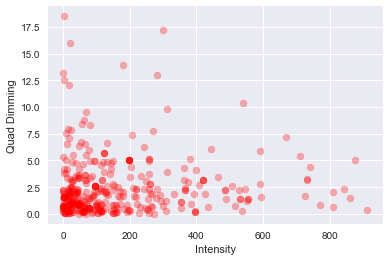

In [55]:
plt.scatter(np.abs(jedi_demon.loc[:, 'Intensity']), quad_arr, alpha = .3, color = 'red');
plt.xlabel('Intensity')
plt.ylabel('Quad Dimming')
plt.savefig('Intensity Vs Quad Dimming')

In [56]:
intensity_df = jedi_demon.filter(regex='Intensity')
intensity_df.insert(1, 'Quad', quad_arr)

In [57]:
intensity_df_nonan = intensity_df.T.dropna(axis=1)

In [58]:
intensity_df_nonan

,7,9,17,19,29,30,54,98,99,100,...,4491,4507,4510,4548,4554,4556,4565,4630,4721,4722
Intensity,-98.000000,-61.000000,-86.000000,-10.000000,-66.000000,-861.000000,-333.000000,-421.000000,-421.000000,-421.000000,...,-255.000000,-104.00000,-80.000000,-17.000000,-22.000000,-51.000000,-77.000000,-20.000000,-537.000000,-295.000000
Quad,0.793027,0.235694,1.570911,0.796247,0.225339,1.466233,1.838593,3.194434,3.194434,3.194434,...,0.445742,1.12096,3.322036,12.023511,1.344916,0.396964,1.322187,0.118151,0.245076,1.203403


In [59]:
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures, Imputer
poly_model = make_pipeline(PolynomialFeatures(5), LinearRegression())
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

# imp = Imputer(strategy='most_frequent')
# X = imp.fit_transform(jedicdaw_condensed.loc[:, '19.5 Depth [%]'][:, np.newaxis])
#X = jedicdaw_condensed.loc[:, '19.5 Depth [%]'][:, np.newaxis]
#y = jedicdaw_condensed.loc[:, 'Flare Class Converted']
X = intensity_df_nonan.T.loc[:, 'Quad'][:, np.newaxis]
y = np.abs(intensity_df_nonan.T.loc[:, 'Intensity'])
X1, X2, y1, y2 = train_test_split(X, y, train_size = .5)

C:\Users\kelly\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



Text(0,0.5,'Intensity')

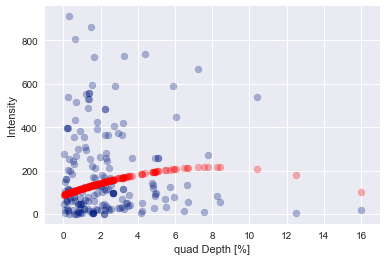

In [60]:
model = make_pipeline(PolynomialFeatures(2), LinearRegression())
model.fit(X1, y1)

y2_model = model.predict(X2)

# inlier_mask = ransac.inlier_mask_
# outlier_mask = np.logical_not(inlier_mask)

plt.scatter(X2, y2, alpha=.3)
plt.scatter(X2, y2_model, alpha=.3, color='red')
plt.xlabel('quad Depth [%]')
plt.ylabel('Intensity')

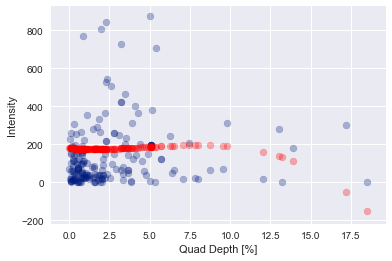

In [61]:
model = make_pipeline(PolynomialFeatures(3), LinearRegression())
model.fit(X2, y2)

y1_model = model.predict(X1)

# inlier_mask = ransac.inlier_mask_
# outlier_mask = np.logical_not(inlier_mask)
model.score(X1, y1_model)
plt.scatter(X1, y1, alpha=.3)
plt.scatter(X1, y1_model, alpha=.3, color='red')
plt.xlabel('Quad Depth [%]')
plt.ylabel('Intensity');

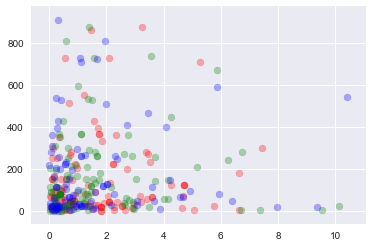

In [62]:
plt.scatter(jedi_demon.loc[:, '17.1 Depth [%]'], np.abs(jedi_demon.loc[:, 'Intensity']), alpha = .3, color = 'red');
plt.scatter(jedi_demon.loc[:, '19.5 Depth [%]'], np.abs(jedi_demon.loc[:, 'Intensity']), alpha = .3, color = 'green');
plt.scatter(jedi_demon.loc[:, '21.1 Depth [%]'], np.abs(jedi_demon.loc[:, 'Intensity']), alpha = .3, color = 'blue');

In [63]:
jedi_demon['Fraction of dimming on disk'] = np.nan
jedi_demon['Fractional size of off-limb dimming contribution'] = np.nan

In [64]:
dimming_size = pd.read_csv('jake_dimming_sizes.csv', low_memory=False)

In [65]:
dimming_size.head(2)

,Event number,Fraction of dimming on disk,Fractional size of off-limb dimming contribution
0,4321,0.030997,0.000008
1,4322,0.008529,0.000008


In [66]:
jedi_demon_eventnum = jedi_demon.loc[:, 'Demon Event #'].values
dimming_size_events = dimming_size.loc[:, 'Event number'].values

In [67]:
for i in range(len(jedi_demon)):
    for k in range(len(dimming_size)):
        if jedi_demon_eventnum[i] == dimming_size_events[k]:
            jedi_demon['Fraction of dimming on disk'].iloc[i] = dimming_size['Fraction of dimming on disk'].iloc[k]
            jedi_demon['Fractional size of off-limb dimming contribution'].iloc[i] = dimming_size['Fractional size of off-limb dimming contribution'].iloc[k]
            
        

C:\Users\kelly\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [68]:
quad_events = quad(jedi_demon.loc[:, '17.1 Depth [%]'].values, jedi_demon.loc[:, '19.5 Depth [%]'].values, 
           jedi_demon.loc[:, '21.1 Depth [%]'].values, jedi_demon.loc[:, '17.7 Depth [%]'].values,
           jedi_demon.loc[:, '28.4 Depth [%]'].values, jedi_demon.loc[:, '20.2 Depth [%]'].values,
           jedi_demon.loc[:, '18.0 Depth [%]'].values)
quad_new_depth = np.array(quad_events)

quad_events = quad(jedi_demon.filter(regex='17.1 Pre-Flare').values, jedi_demon.filter(regex='17.7 Pre-Flare').values, 
           jedi_demon.filter(regex='19.5 Pre-Flare').values, jedi_demon.filter(regex='21.1 Pre-Flare').values,
           jedi_demon.filter(regex='28.4 Pre-Flare').values, jedi_demon.filter(regex='20.2 Pre-Flare').values,
           jedi_demon.filter(regex='18.0 Pre-Flare').values)
quad_new_preFlare = np.array(quad_events)

jedi_demon.insert(6, 'Quad Depth [%]', quad_new_depth)
jedi_demon.insert(12, 'Quad Pre-Flare Irradiance [W/m2]', quad_new_preFlare)

In [69]:
def calc_jedi_intensity(depth, preFlare):
    jedi_intensity = []
    for i in range(len(depth)):
        jedi_intensity.append((depth[i] * preFlare[i]))
    jedi_inten_array = np.array(jedi_intensity)
    return jedi_inten_array

In [70]:
euv171_inten = calc_jedi_intensity(jedi_demon.loc[:, '17.1 Depth [%]'].values, jedi_demon.filter(regex='17.1 Pre-Flare').values)
euv177_inten = calc_jedi_intensity(jedi_demon.loc[:, '17.7 Depth [%]'].values, jedi_demon.filter(regex='17.7 Pre-Flare').values)
euv180_inten = calc_jedi_intensity(jedi_demon.loc[:, '18.0 Depth [%]'].values, jedi_demon.filter(regex='18.0 Pre-Flare').values)
euv195_inten = calc_jedi_intensity(jedi_demon.loc[:, '19.5 Depth [%]'].values, jedi_demon.filter(regex='19.5 Pre-Flare').values)
euv202_inten = calc_jedi_intensity(jedi_demon.loc[:, '20.2 Depth [%]'].values, jedi_demon.filter(regex='20.2 Pre-Flare').values)
euv211_inten = calc_jedi_intensity(jedi_demon.loc[:, '21.1 Depth [%]'].values, jedi_demon.filter(regex='21.1 Pre-Flare').values)
euv284_inten = calc_jedi_intensity(jedi_demon.loc[:, '28.4 Depth [%]'].values, jedi_demon.filter(regex='28.4 Pre-Flare').values)

euvQuad_inten = calc_jedi_intensity(jedi_demon.loc[:, 'Quad Depth [%]'].values, jedi_demon.filter(regex='Quad Pre-Flare').values)

In [71]:
jedi_demon.insert(17, 'Jedi Intensity 17.1', euv171_inten)
jedi_demon.insert(17, 'Jedi Intensity 17.7', euv177_inten)
jedi_demon.insert(17, 'Jedi Intensity 18.0', euv180_inten)
jedi_demon.insert(17, 'Jedi Intensity 19.5', euv195_inten)
jedi_demon.insert(17, 'Jedi Intensity 20.2', euv202_inten)
jedi_demon.insert(17, 'Jedi Intensity 21.1', euv211_inten)
jedi_demon.insert(17, 'Jedi Intensity 28.4', euv284_inten)
jedi_demon.insert(17, 'Jedi Intensity Quad', euvQuad_inten)

In [72]:
def turnIntoSeconds_jedi_demon(timeArray):
    secondArray = []
    for i in range(len (timeArray)):
        timeValue = timeArray[i]
        hours = timeValue[11:13]
        minutes = timeValue[14:16]
        seconds = timeValue[17:19]
        
        secondHours = round(float(hours) * 60 * 60)
        minuteHours = round(float(minutes) * 60)
        secondFloat = float(seconds)
        
        secondArray.append((secondHours + minuteHours + secondFloat))
    return secondArray
            

In [73]:
def time_array_in_sec(depthPercent, depthTime):
    jedi_demon_noNaN = jedi_demon.T.dropna(subset=(depthPercent, depthTime), how='any',axis=1)
    time_arr = jedi_demon_noNaN.T.loc[:, depthTime].values
    time_list = turnIntoSeconds_jedi_demon(time_arr)
    time_array_nonan = np.array(time_list)

    return time_array_nonan, jedi_demon_noNaN.T

In [74]:
GOES_start = jedi_demon.loc[:, 'GOES Flare Start Time'].values
GOES_peak = jedi_demon.loc[:, 'GOES Flare Peak Time'].values

In [75]:
def time_to_peak(start_times, peak_times):
    start = start_times.copy()
    peak = peak_times.copy()
    start_sec = turnIntoSeconds_jedi_demon(start)
    peak_sec = turnIntoSeconds_jedi_demon(peak)
    timeToPeak = time_diff(start_sec, peak_sec)
    return timeToPeak

In [76]:
timeDifftoPeak = time_to_peak(GOES_start, GOES_peak)
jedi_demon.insert(3, 'GOES Flare Time to Peak In Sec', timeDifftoPeak)

In [77]:
total_fraction_of_disk = jedi_demon.filter(like='Fraction').T.sum()
fract_off_limb = jedi_demon.filter(regex='Fractional size of off-limb dimming contribution').values
fract_off_limb.flatten()

percent_off_limb = []
for i in range(len(total_fraction_of_disk)):
    percent_off_limb.append((fract_off_limb.flatten()[i] / total_fraction_of_disk.values[i]) * 100)

In [78]:
is_off_limb = []
count = 0
for i in range(len(percent_off_limb)):
    if percent_off_limb[i] > 75:
        is_off_limb.append(True)
        count += 1
    else:
        is_off_limb.append(False)


is_off_limb_arr = np.array(is_off_limb)
percent_off_limb_arr = np.array(percent_off_limb)

jedi_demon.insert(24324, 'Off-Limb Percent', percent_off_limb_arr)
jedi_demon.insert(24324, 'Is Off-Limb', is_off_limb_arr)

In [79]:
jedi_demon_sub = jedi_demon[['Event #', 'GOES Flare Start Time', 'GOES Flare Peak Time', 'GOES Flare Time to Peak In Sec',
                             'Flare Class Converted', '17.1 Depth [%]', '17.7 Depth [%]', '18.0 Depth [%]',
                             '19.5 Depth [%]', '20.2 Depth [%]', '21.1 Depth [%]', '28.4 Depth [%]', 'Quad Depth [%]',
                             '17.1 Pre-Flare Irradiance [W/m2]', '17.7 Pre-Flare Irradiance [W/m2]',
                             '18.0 Pre-Flare Irradiance [W/m2]', '19.5 Pre-Flare Irradiance [W/m2]',
                             '20.2 Pre-Flare Irradiance [W/m2]', '21.1 Pre-Flare Irradiance [W/m2]',
                             '28.4 Pre-Flare Irradiance [W/m2]', 'Quad Pre-Flare Irradiance [W/m2]', '17.1 Depth Time',
                             '17.7 Depth Time', '18.0 Depth Time', '21.1 Depth Time', '19.5 Depth Time',
                             '20.2 Depth Time', '28.4 Depth Time', 'Jedi Intensity 17.1', 'Jedi Intensity 17.7',
                             'Jedi Intensity 18.0', 'Jedi Intensity 19.5', 'Jedi Intensity 20.2', 'Jedi Intensity 21.1',
                             'Jedi Intensity 28.4', 'Jedi Intensity Quad',
                             'Has DEMON Dimming', 'Intensity', 'Max Drop', 'Demon Event #',
                             'Fraction of dimming on disk', 'Fractional size of off-limb dimming contribution',
                             'Off-Limb Percent', 'Is Off-Limb']]

In [80]:
jedi_demon_events = jedi_demon_sub.dropna(subset=('Intensity', 'Max Drop'), how='any')

In [81]:
jedi_demon_events.head()

,Event #,GOES Flare Start Time,GOES Flare Peak Time,GOES Flare Time to Peak In Sec,Flare Class Converted,17.1 Depth [%],17.7 Depth [%],18.0 Depth [%],19.5 Depth [%],20.2 Depth [%],...,Jedi Intensity 28.4,Jedi Intensity Quad,Has DEMON Dimming,Intensity,Max Drop,Demon Event #,Fraction of dimming on disk,Fractional size of off-limb dimming contribution,Off-Limb Percent,Is Off-Limb
7,9.0,2010-06-12 00:30:00.000,2010-06-12 00:57:00.000,1620.0,2000,0.420038,0.672652,NaN,NaN,NaN,...,NaN,0.000049,True,-98.0,84.0,4324.0,0.010658,0.000173,1.593318,False
9,11.0,2010-06-12 09:02:00.000,2010-06-12 09:17:00.000,900.0,610,0.235694,NaN,NaN,NaN,NaN,...,NaN,0.000015,True,-61.0,104.0,4325.0,0.004628,0.000008,0.177313,False
10,12.0,2010-06-13 05:30:00.000,2010-06-13 05:39:00.000,540.0,1000,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,True,-370.0,376.0,4326.0,0.000288,0.027543,98.966030,True
17,19.0,2010-06-14 00:44:00.000,2010-06-14 00:51:00.000,420.0,150,NaN,NaN,NaN,NaN,1.570911,...,NaN,0.000040,True,-86.0,215.0,4327.0,0.000501,0.006511,92.848768,True
19,21.0,2010-07-09 08:53:00.000,2010-07-09 09:01:00.000,480.0,180,0.570929,0.555022,NaN,NaN,NaN,...,NaN,0.000053,True,-10.0,6.0,4334.0,0.000008,0.000536,98.484779,True


In [82]:
# quad_events = quad(jedi_demon_events.loc[:, '17.1 Depth [%]'].values, jedi_demon_events.loc[:, '19.5 Depth [%]'].values, 
#            jedi_demon_events.loc[:, '21.1 Depth [%]'].values, jedi_demon_events.loc[:, '17.7 Depth [%]'].values,
#            jedi_demon_events.loc[:, '28.4 Depth [%]'].values, jedi_demon_events.loc[:, '20.2 Depth [%]'].values,
#            jedi_demon_events.loc[:, '18.0 Depth [%]'].values)
# quad_events_depth = np.array(quad_events)

In [83]:
# quad_events = quad(jedi_demon_events.filter(regex='17.1 Pre-Flare').values, jedi_demon_events.filter(regex='17.7 Pre-Flare').values, 
#            jedi_demon_events.filter(regex='19.5 Pre-Flare').values, jedi_demon_events.filter(regex='21.1 Pre-Flare').values,
#            jedi_demon_events.filter(regex='28.4 Pre-Flare').values, jedi_demon_events.filter(regex='20.2 Pre-Flare').values,
#            jedi_demon_events.filter(regex='18.0 Pre-Flare').values)
# quad_events_preFlare = np.array(quad_events)

In [84]:
# jedi_demon_events.insert(6, 'Quad Depth [%]', quad_events_depth)
# jedi_demon_events.insert(12, 'Quad Pre-Flare Irradiance [W/m2]', quad_events_preFlare)

In [85]:
# def calc_jedi_intensity(depth, preFlare):
#     jedi_intensity = []
#     for i in range(len(depth)):
#         jedi_intensity.append((depth[i] * preFlare[i]))
#     jedi_inten_array = np.array(jedi_intensity)
#     return jedi_inten_array

In [86]:
# euv171_inten = calc_jedi_intensity(jedi_demon_events.loc[:, '17.1 Depth [%]'].values, jedi_demon_events.filter(regex='17.1 Pre-Flare').values)
# euv177_inten = calc_jedi_intensity(jedi_demon_events.loc[:, '17.7 Depth [%]'].values, jedi_demon_events.filter(regex='17.7 Pre-Flare').values)
# euv180_inten = calc_jedi_intensity(jedi_demon_events.loc[:, '18.0 Depth [%]'].values, jedi_demon_events.filter(regex='18.0 Pre-Flare').values)
# euv195_inten = calc_jedi_intensity(jedi_demon_events.loc[:, '19.5 Depth [%]'].values, jedi_demon_events.filter(regex='19.5 Pre-Flare').values)
# euv202_inten = calc_jedi_intensity(jedi_demon_events.loc[:, '20.2 Depth [%]'].values, jedi_demon_events.filter(regex='20.2 Pre-Flare').values)
# euv211_inten = calc_jedi_intensity(jedi_demon_events.loc[:, '21.1 Depth [%]'].values, jedi_demon_events.filter(regex='21.1 Pre-Flare').values)
# euv284_inten = calc_jedi_intensity(jedi_demon_events.loc[:, '28.4 Depth [%]'].values, jedi_demon_events.filter(regex='28.4 Pre-Flare').values)

# euvQuad_inten = calc_jedi_intensity(jedi_demon_events.loc[:, 'Quad Depth [%]'].values, jedi_demon_events.filter(regex='Quad Pre-Flare').values)

In [87]:
# jedi_demon_events.insert(17, 'Jedi Intensity 17.1', euv171_inten)
# jedi_demon_events.insert(17, 'Jedi Intensity 17.7', euv177_inten)
# jedi_demon_events.insert(17, 'Jedi Intensity 18.0', euv180_inten)
# jedi_demon_events.insert(17, 'Jedi Intensity 19.5', euv195_inten)
# jedi_demon_events.insert(17, 'Jedi Intensity 20.2', euv202_inten)
# jedi_demon_events.insert(17, 'Jedi Intensity 21.1', euv211_inten)
# jedi_demon_events.insert(17, 'Jedi Intensity 28.4', euv284_inten)
# jedi_demon_events.insert(17, 'Jedi Intensity Quad', euvQuad_inten)

In [88]:
jedi_demon_events

,Event #,GOES Flare Start Time,GOES Flare Peak Time,GOES Flare Time to Peak In Sec,Flare Class Converted,17.1 Depth [%],17.7 Depth [%],18.0 Depth [%],19.5 Depth [%],20.2 Depth [%],...,Jedi Intensity 28.4,Jedi Intensity Quad,Has DEMON Dimming,Intensity,Max Drop,Demon Event #,Fraction of dimming on disk,Fractional size of off-limb dimming contribution,Off-Limb Percent,Is Off-Limb
7,9.0,2010-06-12 00:30:00.000,2010-06-12 00:57:00.000,1620.0,2000,0.420038,0.672652,NaN,NaN,NaN,...,NaN,0.000049,True,-98.0,84.0,4324.0,0.010658,0.000173,1.593318,False
9,11.0,2010-06-12 09:02:00.000,2010-06-12 09:17:00.000,900.0,610,0.235694,NaN,NaN,NaN,NaN,...,NaN,0.000015,True,-61.0,104.0,4325.0,0.004628,0.000008,0.177313,False
10,12.0,2010-06-13 05:30:00.000,2010-06-13 05:39:00.000,540.0,1000,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,True,-370.0,376.0,4326.0,0.000288,0.027543,98.966030,True
17,19.0,2010-06-14 00:44:00.000,2010-06-14 00:51:00.000,420.0,150,NaN,NaN,NaN,NaN,1.570911,...,NaN,0.000040,True,-86.0,215.0,4327.0,0.000501,0.006511,92.848768,True
19,21.0,2010-07-09 08:53:00.000,2010-07-09 09:01:00.000,480.0,180,0.570929,0.555022,NaN,NaN,NaN,...,NaN,0.000053,True,-10.0,6.0,4334.0,0.000008,0.000536,98.484779,True
20,22.0,2010-07-09 19:26:00.000,2010-07-09 19:51:00.000,1500.0,340,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,True,-85.0,111.0,4335.0,0.000008,0.006422,99.872020,True
24,26.0,2010-07-17 17:27:00.000,2010-07-17 18:01:00.000,2040.0,240,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,True,-324.0,162.0,4338.0,0.012878,0.000008,0.063866,False
29,31.0,2010-08-05 20:39:00.000,2010-08-05 21:35:00.000,3360.0,130,NaN,NaN,NaN,0.225339,NaN,...,NaN,0.000008,True,-66.0,62.0,4348.0,0.002754,0.003746,57.629265,False
30,32.0,2010-08-07 17:55:00.000,2010-08-07 18:24:00.000,1740.0,1000,1.466233,NaN,NaN,NaN,NaN,...,NaN,0.000086,True,-861.0,686.0,4350.0,0.051104,0.000066,0.128006,False
34,37.0,2010-08-17 23:05:00.000,2010-08-18 00:01:00.000,3360.0,150,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,True,-44.0,26.0,4358.0,0.000008,0.006792,99.880012,True


(-0.0001, 0.002)

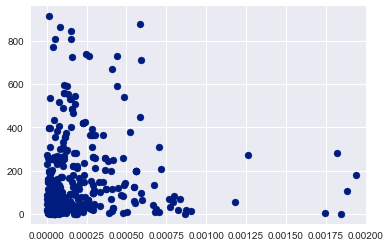

In [89]:
Jedi_intensity = jedi_demon_events.loc[:, 'Jedi Intensity Quad'].values
for i in range(len(Jedi_intensity)):
    if Jedi_intensity[i] == 0:
        Jedi_intensity[i] = np.nan
        
Jedi_intensity
        
plt.scatter(Jedi_intensity, np.abs(jedi_demon_events.loc[:, 'Intensity']))
plt.xlim(-.0001, .002)


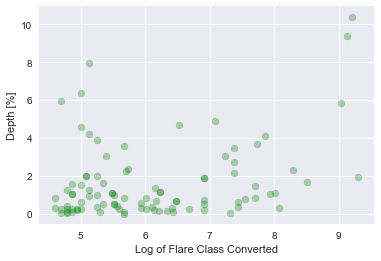

In [90]:
#plt.scatter(np.log(jedi_demon_events.loc[:, 'Flare Class Converted']), jedi_demon_events.loc[:, '17.1 Depth [%]'],
#            alpha=.3, color='steelblue')
# plt.scatter(np.log(jedi_demon_events.loc[:, 'Flare Class Converted']), jedi_demon_events.loc[:, '19.5 Depth [%]'],
#            alpha=.3, color='red')
plt.scatter(np.log(jedi_demon_events.loc[:, 'Flare Class Converted']), jedi_demon_events.loc[:, '21.1 Depth [%]'],
            alpha=.3, color='green')
plt.xlabel('Log of Flare Class Converted');
plt.ylabel('Depth [%]');

In [91]:
jedi_demon_events

,Event #,GOES Flare Start Time,GOES Flare Peak Time,GOES Flare Time to Peak In Sec,Flare Class Converted,17.1 Depth [%],17.7 Depth [%],18.0 Depth [%],19.5 Depth [%],20.2 Depth [%],...,Jedi Intensity 28.4,Jedi Intensity Quad,Has DEMON Dimming,Intensity,Max Drop,Demon Event #,Fraction of dimming on disk,Fractional size of off-limb dimming contribution,Off-Limb Percent,Is Off-Limb
7,9.0,2010-06-12 00:30:00.000,2010-06-12 00:57:00.000,1620.0,2000,0.420038,0.672652,NaN,NaN,NaN,...,NaN,0.000049,True,-98.0,84.0,4324.0,0.010658,0.000173,1.593318,False
9,11.0,2010-06-12 09:02:00.000,2010-06-12 09:17:00.000,900.0,610,0.235694,NaN,NaN,NaN,NaN,...,NaN,0.000015,True,-61.0,104.0,4325.0,0.004628,0.000008,0.177313,False
10,12.0,2010-06-13 05:30:00.000,2010-06-13 05:39:00.000,540.0,1000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,True,-370.0,376.0,4326.0,0.000288,0.027543,98.966030,True
17,19.0,2010-06-14 00:44:00.000,2010-06-14 00:51:00.000,420.0,150,NaN,NaN,NaN,NaN,1.570911,...,NaN,0.000040,True,-86.0,215.0,4327.0,0.000501,0.006511,92.848768,True
19,21.0,2010-07-09 08:53:00.000,2010-07-09 09:01:00.000,480.0,180,0.570929,0.555022,NaN,NaN,NaN,...,NaN,0.000053,True,-10.0,6.0,4334.0,0.000008,0.000536,98.484779,True
20,22.0,2010-07-09 19:26:00.000,2010-07-09 19:51:00.000,1500.0,340,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,True,-85.0,111.0,4335.0,0.000008,0.006422,99.872020,True
24,26.0,2010-07-17 17:27:00.000,2010-07-17 18:01:00.000,2040.0,240,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,True,-324.0,162.0,4338.0,0.012878,0.000008,0.063866,False
29,31.0,2010-08-05 20:39:00.000,2010-08-05 21:35:00.000,3360.0,130,NaN,NaN,NaN,0.225339,NaN,...,NaN,0.000008,True,-66.0,62.0,4348.0,0.002754,0.003746,57.629265,False
30,32.0,2010-08-07 17:55:00.000,2010-08-07 18:24:00.000,1740.0,1000,1.466233,NaN,NaN,NaN,NaN,...,NaN,0.000086,True,-861.0,686.0,4350.0,0.051104,0.000066,0.128006,False
34,37.0,2010-08-17 23:05:00.000,2010-08-18 00:01:00.000,3360.0,150,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,True,-44.0,26.0,4358.0,0.000008,0.006792,99.880012,True


In [92]:
# def turnIntoSeconds_jedi_demon(timeArray):
#     secondArray = []
#     for i in range(len (timeArray)):
#         timeValue = timeArray[i]
#         hours = timeValue[11:13]
#         minutes = timeValue[14:16]
#         seconds = timeValue[17:19]
        
#         secondHours = round(float(hours) * 60 * 60)
#         minuteHours = round(float(minutes) * 60)
#         secondFloat = float(seconds)
        
#         secondArray.append((secondHours + minuteHours + secondFloat))
#     return secondArray
            

In [93]:
def events_time_array_in_sec(depthPercent, depthTime):
    jedi_events_noNaN = jedi_demon_events.T.dropna(subset=(depthPercent, depthTime), how='any',axis=1)
    time_arr = jedi_events_noNaN.T.loc[:, depthTime].values
    time_list = turnIntoSeconds_jedi_demon(time_arr)
    time_array_nonan = np.array(time_list)

    return time_array_nonan, jedi_events_noNaN.T

In [94]:

time171arr, eventFor171 = events_time_array_in_sec('17.1 Depth [%]', '17.1 Depth Time')
time211arr, eventFor211 = events_time_array_in_sec('21.1 Depth [%]', '21.1 Depth Time')
time195arr, eventFor195 = events_time_array_in_sec('19.5 Depth [%]', '19.5 Depth Time')


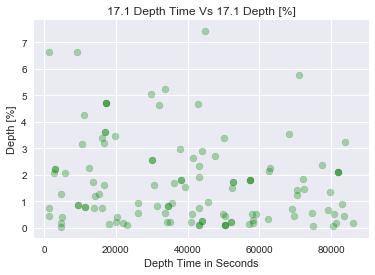

In [95]:
plt.scatter(time171arr, eventFor171.loc[:, '17.1 Depth [%]'],alpha=.3, color='green')
#plt.scatter(time211arr, eventFor211.loc[:, '21.1 Depth [%]'], alpha=.3, color='blue')
#plt.scatter(time195arr, eventFor195.loc[:, '19.5 Depth [%]'], alpha=.3, color='red')

plt.xlabel('Depth Time in Seconds');
plt.ylabel('Depth [%]');
plt.title('17.1 Depth Time Vs 17.1 Depth [%]')
plt.savefig('17.1 Depth Time Vs 17.1 Depth Percent.png')

In [96]:
time171arr, eventFor171 = events_time_array_in_sec('17.1 Depth [%]', '17.1 Depth Time')

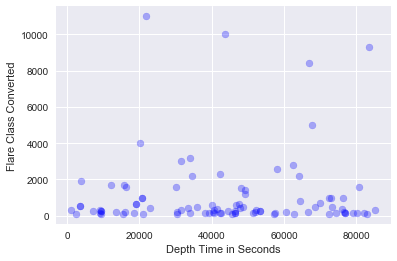

In [97]:
#plt.scatter(time171arr, eventFor171.loc[:, 'Flare Class Converted'],alpha=.3, color='green')
plt.scatter(time211arr, eventFor211.loc[:, 'Flare Class Converted'], alpha=.3, color='blue')

plt.xlabel('Depth Time in Seconds');
plt.ylabel('Flare Class Converted');

In [98]:
columns = jedi_demon.filter(like= 'Depth [%]').columns
columns = columns[:39]
columns

Index(['Quad Depth [%]', '9.4 Depth [%]', '13.1 Depth [%]', '13.3 Depth [%]',
       '17.1 Depth [%]', '17.7 Depth [%]', '18.0 Depth [%]', '19.5 Depth [%]',
       '20.2 Depth [%]', '21.1 Depth [%]', '25.6 Depth [%]', '28.4 Depth [%]',
       '30.4 Depth [%]', '33.5 Depth [%]', '36.1 Depth [%]', '36.8 Depth [%]',
       '44.6 Depth [%]', '46.5 Depth [%]', '49.9 Depth [%]', '52.1 Depth [%]',
       '52.6 Depth [%]', '53.7 Depth [%]', '55.4 Depth [%]', '56.8 Depth [%]',
       '58.4 Depth [%]', '59.2 Depth [%]', '60.0 Depth [%]', '61.0 Depth [%]',
       '62.5 Depth [%]', '63.0 Depth [%]', '71.9 Depth [%]', '72.2 Depth [%]',
       '77.0 Depth [%]', '79.0 Depth [%]', '83.6 Depth [%]', '95.0 Depth [%]',
       '97.3 Depth [%]', '97.7 Depth [%]', '102.6 Depth [%]'],
      dtype='object')

In [99]:
euv_common = jedi_demon.loc[:, columns].T.idxmax().dropna()

In [100]:
jedi_demon_events

,Event #,GOES Flare Start Time,GOES Flare Peak Time,GOES Flare Time to Peak In Sec,Flare Class Converted,17.1 Depth [%],17.7 Depth [%],18.0 Depth [%],19.5 Depth [%],20.2 Depth [%],...,Jedi Intensity 28.4,Jedi Intensity Quad,Has DEMON Dimming,Intensity,Max Drop,Demon Event #,Fraction of dimming on disk,Fractional size of off-limb dimming contribution,Off-Limb Percent,Is Off-Limb
7,9.0,2010-06-12 00:30:00.000,2010-06-12 00:57:00.000,1620.0,2000,0.420038,0.672652,NaN,NaN,NaN,...,NaN,0.000049,True,-98.0,84.0,4324.0,0.010658,0.000173,1.593318,False
9,11.0,2010-06-12 09:02:00.000,2010-06-12 09:17:00.000,900.0,610,0.235694,NaN,NaN,NaN,NaN,...,NaN,0.000015,True,-61.0,104.0,4325.0,0.004628,0.000008,0.177313,False
10,12.0,2010-06-13 05:30:00.000,2010-06-13 05:39:00.000,540.0,1000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,True,-370.0,376.0,4326.0,0.000288,0.027543,98.966030,True
17,19.0,2010-06-14 00:44:00.000,2010-06-14 00:51:00.000,420.0,150,NaN,NaN,NaN,NaN,1.570911,...,NaN,0.000040,True,-86.0,215.0,4327.0,0.000501,0.006511,92.848768,True
19,21.0,2010-07-09 08:53:00.000,2010-07-09 09:01:00.000,480.0,180,0.570929,0.555022,NaN,NaN,NaN,...,NaN,0.000053,True,-10.0,6.0,4334.0,0.000008,0.000536,98.484779,True
20,22.0,2010-07-09 19:26:00.000,2010-07-09 19:51:00.000,1500.0,340,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,True,-85.0,111.0,4335.0,0.000008,0.006422,99.872020,True
24,26.0,2010-07-17 17:27:00.000,2010-07-17 18:01:00.000,2040.0,240,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,True,-324.0,162.0,4338.0,0.012878,0.000008,0.063866,False
29,31.0,2010-08-05 20:39:00.000,2010-08-05 21:35:00.000,3360.0,130,NaN,NaN,NaN,0.225339,NaN,...,NaN,0.000008,True,-66.0,62.0,4348.0,0.002754,0.003746,57.629265,False
30,32.0,2010-08-07 17:55:00.000,2010-08-07 18:24:00.000,1740.0,1000,1.466233,NaN,NaN,NaN,NaN,...,NaN,0.000086,True,-861.0,686.0,4350.0,0.051104,0.000066,0.128006,False
34,37.0,2010-08-17 23:05:00.000,2010-08-18 00:01:00.000,3360.0,150,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,True,-44.0,26.0,4358.0,0.000008,0.006792,99.880012,True


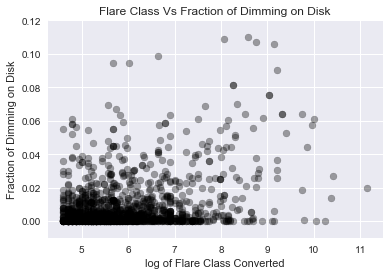

In [101]:
quad_depth = jedi_demon_events.loc[:, 'Quad Depth [%]'].values
for i in range(len(quad_depth)):
    if quad_depth[i] == 0 or quad_depth[i] > 20:
        quad_depth[i] = np.nan
    
plt.scatter(np.log(jedi_demon_events.loc[:, 'Flare Class Converted']), jedi_demon_events.loc[:, 'Fraction of dimming on disk'],
            alpha =.35, color='black')
plt.ylim(-0.01, 0.12)
plt.xlabel('log of Flare Class Converted')
plt.ylabel('Fraction of Dimming on Disk')
plt.title('Flare Class Vs Fraction of Dimming on Disk')
plt.savefig('Flare Class Vs Fraction of Dimming on Disk')

In [102]:
time171arr, eventFor171 = events_time_array_in_sec('17.1 Depth [%]', '17.1 Depth Time')
time177arr, eventFor177 = events_time_array_in_sec('17.7 Depth [%]', '17.7 Depth Time')
time211arr, eventFor211 = events_time_array_in_sec('21.1 Depth [%]', '21.1 Depth Time')
time195arr, eventFor195 = events_time_array_in_sec('19.5 Depth [%]', '19.5 Depth Time')
time284arr, eventFor284 = events_time_array_in_sec('28.4 Depth [%]', '28.4 Depth Time')


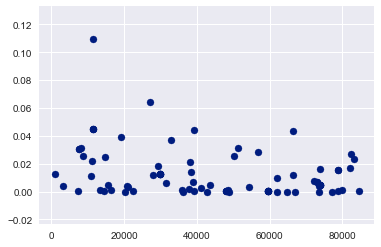

In [103]:

plt.scatter(time284arr, eventFor284.loc[:, 'Fraction of dimming on disk'])

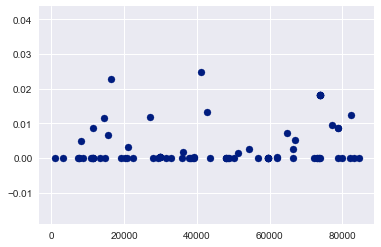

In [104]:
plt.scatter(time284arr, eventFor284.loc[:, 'Fractional size of off-limb dimming contribution'])

In [105]:
# GOES_start = jedi_demon_events.loc[:, 'GOES Flare Start Time'].values
# GOES_peak = jedi_demon_events.loc[:, 'GOES Flare Peak Time'].values

In [106]:
# def time_to_peak(start_times, peak_times):
#     start = start_times.copy()
#     peak = peak_times.copy()
#     start_sec = turnIntoSeconds_jedi_demon(start)
#     peak_sec = turnIntoSeconds_jedi_demon(peak)
#     timeToPeak = time_diff(start_sec, peak_sec)
#     return timeToPeak
    
    
    

In [107]:
# timeDifftoPeak = time_to_peak(GOES_start, GOES_peak)

In [108]:
# jedi_demon_events.insert(3, 'GOES Flare Time to Peak In Sec', timeDifftoPeak)

In [109]:
# total_fraction_of_disk = jedi_demon_events.filter(like='Fraction').T.sum()
# fract_off_limb = jedi_demon_events.filter(regex='Fractional size of off-limb dimming contribution').values
# fract_off_limb.flatten().shape

In [110]:

# percent_off_limb = []
# for i in range(len(total_fraction_of_disk)):
#     percent_off_limb.append((fract_off_limb.flatten()[i] / total_fraction_of_disk.values[i]) * 100)

In [111]:
# is_off_limb = []
# count = 0
# for i in range(len(percent_off_limb)):
#     if percent_off_limb[i] > 75:
#         is_off_limb.append(True)
#         count += 1
#     else:
#         is_off_limb.append(False)


In [112]:

# is_off_limb_arr = np.array(is_off_limb)
# percent_off_limb_arr = np.array(percent_off_limb)



In [113]:
# jedi_demon_events.insert(34, 'Off-Limb Percent', percent_off_limb_arr)
# jedi_demon_events.insert(34, 'Is Off-Limb', is_off_limb_arr)

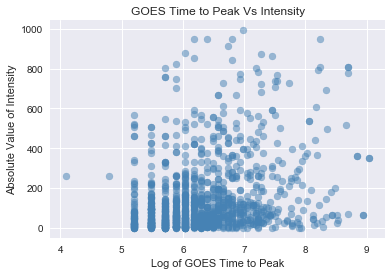

In [114]:
plt.scatter(np.log(jedi_demon_events.loc[:, 'GOES Flare Time to Peak In Sec']), np.abs(jedi_demon_events.loc[:, 'Intensity']),
            color='steelblue', alpha=.5);
plt.xlabel('Log of GOES Time to Peak')
plt.ylabel('Absolute Value of Intensity');
plt.title('GOES Time to Peak Vs Intensity');
plt.savefig('GOES Time to Peak Vs Intensity')

In [115]:
jedi_demon_events.head(1)

,Event #,GOES Flare Start Time,GOES Flare Peak Time,GOES Flare Time to Peak In Sec,Flare Class Converted,17.1 Depth [%],17.7 Depth [%],18.0 Depth [%],19.5 Depth [%],20.2 Depth [%],...,Jedi Intensity 28.4,Jedi Intensity Quad,Has DEMON Dimming,Intensity,Max Drop,Demon Event #,Fraction of dimming on disk,Fractional size of off-limb dimming contribution,Off-Limb Percent,Is Off-Limb
7,9.0,2010-06-12 00:30:00.000,2010-06-12 00:57:00.000,1620.0,2000,0.420038,0.672652,NaN,NaN,NaN,...,NaN,0.000049,True,-98.0,84.0,4324.0,0.010658,0.000173,1.593318,False


In [116]:
jedi_demon_events_copy = jedi_demon_events
jedi_demon_events_off_limb = jedi_demon_events_copy[jedi_demon_events_copy['Is Off-Limb'] != False]

In [117]:
jedi_demon_events_off_limb

,Event #,GOES Flare Start Time,GOES Flare Peak Time,GOES Flare Time to Peak In Sec,Flare Class Converted,17.1 Depth [%],17.7 Depth [%],18.0 Depth [%],19.5 Depth [%],20.2 Depth [%],...,Jedi Intensity 28.4,Jedi Intensity Quad,Has DEMON Dimming,Intensity,Max Drop,Demon Event #,Fraction of dimming on disk,Fractional size of off-limb dimming contribution,Off-Limb Percent,Is Off-Limb
10,12.0,2010-06-13 05:30:00.000,2010-06-13 05:39:00.000,540.0,1000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,True,-370.0,376.0,4326.0,0.000288,0.027543,98.966030,True
17,19.0,2010-06-14 00:44:00.000,2010-06-14 00:51:00.000,420.0,150,NaN,NaN,NaN,NaN,1.570911,...,NaN,0.000040,True,-86.0,215.0,4327.0,0.000501,0.006511,92.848768,True
19,21.0,2010-07-09 08:53:00.000,2010-07-09 09:01:00.000,480.0,180,0.570929,0.555022,NaN,NaN,NaN,...,NaN,0.000053,True,-10.0,6.0,4334.0,0.000008,0.000536,98.484779,True
20,22.0,2010-07-09 19:26:00.000,2010-07-09 19:51:00.000,1500.0,340,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,True,-85.0,111.0,4335.0,0.000008,0.006422,99.872020,True
34,37.0,2010-08-17 23:05:00.000,2010-08-18 00:01:00.000,3360.0,150,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,True,-44.0,26.0,4358.0,0.000008,0.006792,99.880012,True
35,37.0,2010-08-17 23:05:00.000,2010-08-18 00:01:00.000,3360.0,150,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,True,-44.0,26.0,4358.0,0.000008,0.006792,99.880012,True
82,65.0,2010-11-03 05:54:00.000,2010-11-03 06:11:00.000,1020.0,380,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,True,-441.0,384.0,4383.0,0.000086,0.020363,99.577981,True
83,66.0,2010-11-03 12:07:00.000,2010-11-03 12:21:00.000,840.0,490,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,True,-458.0,377.0,4384.0,0.000008,0.018756,99.958218,True
86,69.0,2010-11-04 23:30:00.000,2010-11-04 23:58:00.000,1680.0,1600,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,True,-66.0,112.0,4385.0,0.000008,0.002351,99.667621,True
95,75.0,2010-11-06 15:27:00.000,2010-11-06 15:36:00.000,540.0,5400,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,True,-116.0,50.0,4387.0,0.000070,0.012570,99.443038,True


In [118]:
jedi_demon_events.to_csv('Jedi_Demon_Events.csv', header=True, index=False, mode='w')
jedi_demon.to_csv('Jedi_Demon_Additional_Data.csv', header=True, index=False, mode='w')